In [1]:
import pandas as pd
from utils import *

In [2]:
datafolder = '../data/final_database/'
testfolder = '../data/test/'
extension = '.parquet'
positive_file = datafolder + 'positive' + extension
combined_search = datafolder + 'combined_search' + extension

cols = ['id','text','created_at','url']

# Load datasets

In [3]:
posdf = pd.read_parquet(positive_file)
unlabel = pd.read_parquet(combined_search)

In [6]:
unlabel['created_at'] = pd.to_datetime(unlabel['created_at'])

# print min and max dates
print('Min date: ', unlabel['created_at'].min())
print('Max date: ', unlabel['created_at'].max())
print(unlabel.shape)

Min date:  2016-10-31 00:03:34+00:00
Max date:  2023-05-07 23:00:46+00:00
(319114, 45)


# Filter entries

In [20]:
def delete_tweets(df):
    print('Initial shape:', df.shape)
    df = df[df['author_id'] != fogocruzado_id]
    print('After removing Fogo Cruzado tweets:', df.shape)
    # remove duplicates
    df = df.drop_duplicates(subset=['text'])
    print('After removing duplicates texts:', df.shape)
    print('Before removing replies:', df.shape)
    df = df[df['in_reply_to_user_id'].isnull()]
    print('After removing replies:', df.shape)
    remove_txts = ['is temporarily unavailable','@fogocruzadoapp','fogocruzado','#FogoCruzadoRJ']

    for txt in remove_txts:
        df = df[~df['text'].str.contains(txt)]
        # df['entities.urls'] = df['entities.urls'].astype(str)
        # df = df[~df['entities.urls'].str.contains(txt)]
        print(f'After removing {txt}:', df.shape)
    
    return df

def set_asdatime(df,col):
    df[col] = pd.to_datetime(df[col])
    return df

def process_dataset(df):
    df = delete_tweets(df)
    df = set_asdatime(df,'created_at')
    df = df[cols]
    return df

In [21]:
posdf = process_dataset(posdf)[cols]

Initial shape: (36241, 45)
After removing Fogo Cruzado tweets: (31632, 45)
After removing duplicates texts: (28661, 45)
Before removing replies: (28661, 45)
After removing replies: (26084, 45)
After removing is temporarily unavailable: (26059, 45)
After removing @fogocruzadoapp: (25981, 45)
After removing fogocruzado: (25980, 45)
After removing #FogoCruzadoRJ: (25978, 45)


In [23]:
unlabel = process_dataset(unlabel)[cols]

Initial shape: (319114, 45)
After removing Fogo Cruzado tweets: (261410, 45)
After removing duplicates texts: (250176, 45)
Before removing replies: (250176, 45)
After removing replies: (207344, 45)
After removing is temporarily unavailable: (207270, 45)
After removing @fogocruzadoapp: (207238, 45)
After removing fogocruzado: (207238, 45)
After removing #FogoCruzadoRJ: (207233, 45)


# Delete duplicates

In [24]:
# delete tweets from unlabel that are in posdf
unlabel = unlabel[~unlabel['id'].isin(posdf['id'])]

# Join datasets

In [25]:
posdf['label'] = 1
unlabel['label'] = -1

df = pd.concat([posdf,unlabel])

df.value_counts('label',normalize=True)

label
-1    0.886859
 1    0.113141
dtype: float64

# Plot total per month

/tmp/ipykernel_107940/956888619.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.groupby(df['created_at'].dt.to_period('M')).count()['id'].plot(kind='bar')


<Axes: xlabel='created_at'>

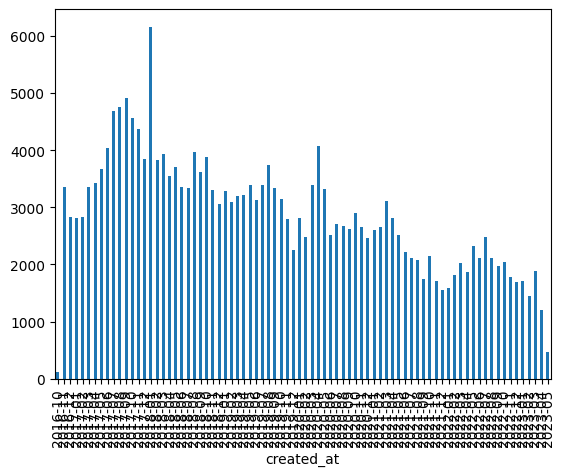

In [26]:
# group by month and count tweets

df.groupby(df['created_at'].dt.to_period('M')).count()['id'].plot(kind='bar')


# Filter only 2023

/tmp/ipykernel_107940/4231050707.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  test.groupby(test['created_at'].dt.to_period('M')).count()['id'].plot(kind='bar')


<Axes: xlabel='created_at'>

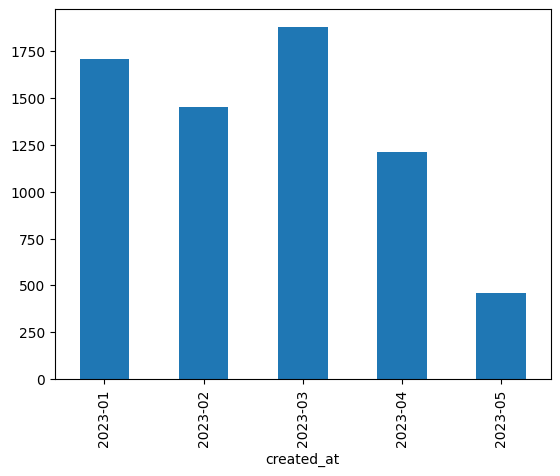

In [27]:
# filter only April 2023

test = df[df['created_at'].dt.year == 2023]

test.groupby(test['created_at'].dt.to_period('M')).count()['id'].plot(kind='bar')

In [28]:
# filter only msgs after April 2023

test = test[test['created_at'].dt.month == 4]

test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1211 entries, 0 to 46
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   id          1211 non-null   object             
 1   text        1211 non-null   object             
 2   created_at  1211 non-null   datetime64[ns, UTC]
 3   url         1211 non-null   object             
 4   label       1211 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(3)
memory usage: 56.8+ KB


In [30]:
test.to_csv(testfolder + 'test_raw.csv',index=False)